# Analysis

### Input:
All feature, eigen data for SimulationData object:
- `sd.dihedrals`
- `sd.features`
- `sd.cvs`
- `sd.eigvals`
- `sd.timescales`
- `sd.psi`
- `sd.theta_grid`
- `sd.psi_grid`
- `sd.cvs_grid`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import mdtraj as md
import os

from src.data import OpenMMData

sd = OpenMMData('data/ala2_solv')
# sd = OpenMMData('data/ala2_solv.0.05ps', lagframes=20)

# Simulation in terms of states and transitions

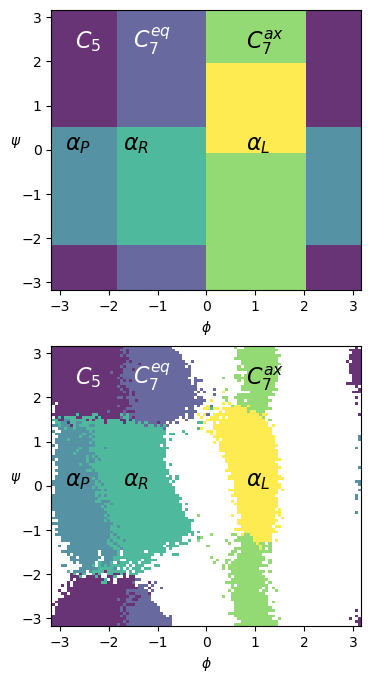

In [9]:
from src.util import dill_state, psi_state
from src.plots import plot_state_labels
    
recalculate = False

fn = f'{sd.dir}/states_dill_grid.npy'
if not os.path.isfile(fn) or recalculate:
    dill_states_grid = np.full(sd.psi_grid.shape[:-1], 0)
    for i, phi_ in enumerate(sd.theta_grid):
        for j, psi_ in enumerate(sd.theta_grid):
            dill_states_grid[i, j] = dill_state(phi_, psi_)
    np.save(fn, dill_states_grid)
else:
    dill_states_grid = np.load(fn)

fn = f'{sd.dir}/states_psi_grid.npy'
if not os.path.isfile(fn) or recalculate:
    psi_states_grid = np.full(sd.psi_grid.shape[:-1], np.nan)
    for i in range(len(sd.theta_grid)):
        for j in range(len(sd.theta_grid)):
            psi_states_grid[i, j] = psi_state(sd.psi_grid[i, j])
else:
    psi_states_grid = np.load(fn)
    
# fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))
fig, axs = plt.subplots(2, 1, figsize=(4, 8))
plot_state_labels(axs, sd, dill_states_grid, psi_states_grid)
fig.savefig('figures/dill-psi-states.png', bbox_inches='tight')
fig.savefig('figures/dill-psi-states.svg', bbox_inches='tight')

In [3]:
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# cb = ax.pcolormesh(sd.theta_grid, sd.theta_grid, psi_states_grid.T, alpha=0.8)
# ax.text(-2.7, 2.3, r'$C_5$', color='white', fontsize=16)
# ax.text(-1.5, 2.3, r'$C_7^{eq}$', color='white', fontsize=16)
# ax.text(0.8, 2.3, r'$C_7^{ax}$', color='black', fontsize=16)
# ax.text(-2.9, 0, r'$\alpha_P$', color='black', fontsize=16)
# ax.text(-1.7, 0, r'$\alpha_R$', color='black', fontsize=16)
# ax.text(0.8, 0, r'$\alpha_L$', color='black', fontsize=16)
# ax.set_xlabel(r'$\phi$')
# ax.set_ylabel(r'$\psi$', rotation=0)
# # fig.savefig('figures/psi-labeled-states.png', bbox_inches='tight')

# Simulation in terms of $\phi(t)$ and $\psi_1(x_t)$

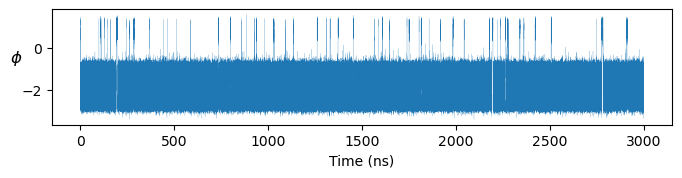

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 1.5))
tau_ns = sd.lagtime / sd.lagframes / 1000
time_ns = np.arange(0, len(sd.dihedrals) * tau_ns, tau_ns)
# wrap C7eq states together
phi_t = sd.dihedrals[:, 0].copy()
phi_t[phi_t > 2] -= 2 * np.pi

ax.plot(time_ns, phi_t, '-', linewidth=0.1)
ax.set_ylabel(r'$\phi$', rotation=0, fontsize=12)
ax.set_xlabel('Time (ns)')
# ax.set_xticklabels('')
fig.savefig('figures/trajectory-phi.png', bbox_inches='tight')
fig.savefig('figures/trajectory-phi.svg', bbox_inches='tight')

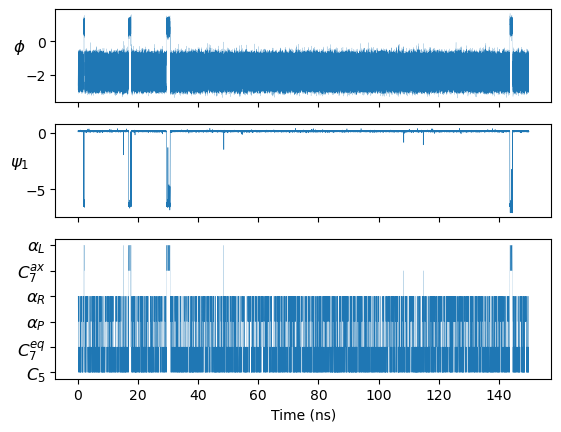

In [5]:
from src.plots import plot_trajectory

recalculate = False
    
fn = f'{sd.dir}/states_dill.npy'
if not os.path.isfile(fn) or recalculate:
    states_dill = np.array([dill_state(*dihedral) for dihedral in sd.dihedrals])
    np.save(fn, states_dill)
else:
    states_dill = np.load(fn)
    
fn = f'{sd.dir}/states_psi.npy'
if not os.path.isfile(fn) or recalculate:
    states_psi = np.array([psi_state(psi) for psi in sd.psi])
    np.save(fn, states_psi)
else:
    states_psi = np.load(fn)

fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1, 1.5]})
plot_trajectory(axs, OpenMMData('data/ala2_solv.0.05ps', lagframes=20))
plt.savefig('figures/trajectory-0.05ps.png', bbox_inches='tight')
plt.savefig('figures/trajectory-0.05ps.svg', bbox_inches='tight')

# Transitions, mean transition time

In [6]:
sides = np.where(states_psi < 5, 0, 1)
transitions = sides[1:] - sides[:-1]
sim_time_ns = sd.lagtime * len(states_psi) / 1000
print(f'number of forward transitions = {transitions[transitions == 1].sum()}')
print(f'number of backward transitions = {transitions[transitions == -1].sum()}')
print(f'mean transition time = {sim_time_ns / transitions[transitions == 1].sum():.2f} ns')

number of forward transitions = 62
number of backward transitions = -62
mean transition time = 48.39 ns


# Error analysis based on transition counts

1. How symmetric is counts matrix (i.e. how well does it obey detailed balance)?  Look at
$$ 1 - \frac{||\frac{1}{2}(A - A^\top)||_F}{||\frac{1}{2}(A + A^\top)||_F}  $$

2. Chapman-Kolmogorov test
$$  T(\tau)^k \approx T(k\tau) $$

3. Timescale estimates should be independent of $\tau$
$$ \tau_i = -\frac{\tau}{\log \lambda_i(\tau)} $$

In [7]:
from src.util import transition_counts_matrix

def symmetriness(a):
    a_a = 0.5 * (a - a.T)
    a_s = 0.5 * (a + a.T)
    return 1 - np.linalg.norm(a_a, ord='fro') / np.linalg.norm(a_s, ord='fro')

k_max = 10
kvals = np.arange(1, k_max + 1)
recalculate = False

counts_dill = [transition_counts_matrix(states_dill, sd.dir, 'dill', lagframes=k, recalculate=recalculate)
               for k in kvals]
counts_psi = [transition_counts_matrix(states_psi, sd.dir, 'psi', lagframes=k, recalculate=recalculate)
               for k in kvals]

symmetry_measure_dill = symmetriness(counts_dill[0])
symmetry_measure_psi = symmetriness(counts_psi[0])
print(f'{symmetry_measure_dill = }')
print(f'{symmetry_measure_psi = }')
print('Counts based on psi are',
      (1 - symmetry_measure_dill) / (1 - symmetry_measure_psi),
      'times less antisymmetrical')

symmetry_measure_dill = 0.9998268914260707
symmetry_measure_psi = 0.9999634719137107
Counts based on psi are 4.739054013350533 times less antisymmetrical


np.allclose(tmatrices_psi[0], koopman_matrix_dmd(chi), atol=1e-3) = True


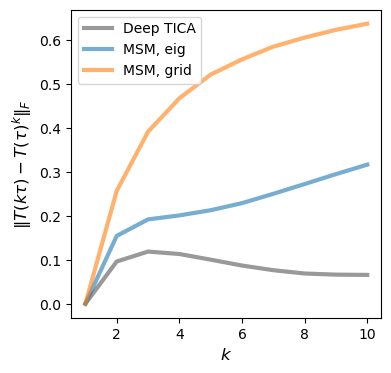

In [8]:
from src.util import pi_mle, transition_matrix_mle, chi_data
from src.util import koopman_matrix_dmd #, chapman_kolmogorov
from src.plots import plot_chapman_kolmogorov

def chapman_kolmogorov(tmatrices):
    """Do Chapman-Kolmogorov test on a list of transition matrices:
        [T(tau), ..., T(n tau)]

    Return : list of terms MSE( T(k * tau), T(tau)^k )
    """
    # def mse(a, b):
    #     return ((a - b)**2).mean()
    # return [mse(tm, np.linalg.matrix_power(tmatrices[0], k + 1))
    #         for k, tm in enumerate(tmatrices)]
    return [np.linalg.norm(tm - np.linalg.matrix_power(tmatrices[0], k + 1), ord='fro')
            for k, tm in enumerate(tmatrices)]   

tmatrices_dill = [transition_matrix_mle(c) for c in counts_dill]
tmatrices_psi = [transition_matrix_mle(c) for c in counts_psi]
kmatrices_srv = [koopman_matrix_dmd(sd.psi.T, lagframes=k) for k in kvals]

# Check that DMD generalizes to MSM transition matrices
chi = chi_data(states_psi)
print(f'{np.allclose(tmatrices_psi[0], koopman_matrix_dmd(chi), atol=1e-3) = }')

ck_dill = chapman_kolmogorov(tmatrices_dill)
ck_psi = chapman_kolmogorov(tmatrices_psi)
ck_srv = chapman_kolmogorov(kmatrices_srv)
    
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_chapman_kolmogorov(ax, kvals, ck_srv, ck_psi, ck_dill)
fig.savefig('figures/chapman-kolmogorov.png', bbox_inches='tight')
fig.savefig('figures/chapman-kolmogorov.svg', bbox_inches='tight')

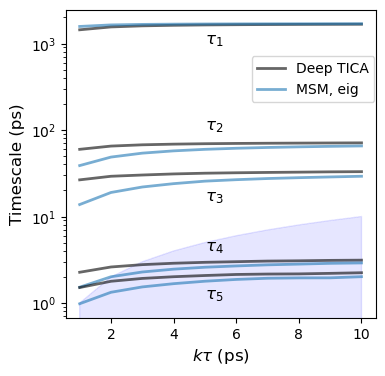

In [14]:
from src.util import eigvals, timescales, rayleigh_quotient
from src.plots import plot_timescales

eigvals_dill = np.vstack([eigvals(tm) for tm in tmatrices_dill])
eigvals_psi = np.vstack([eigvals(tm) for tm in tmatrices_psi])
eigvals_srv = np.vstack([
    np.array([rayleigh_quotient(psi, lagframes=k) for psi in sd.psi.T[:-1]])
    for k in kvals
])

timescales_dill = np.vstack([timescales(evs, (k + 1) * sd.lagtime) 
                             for k, evs in enumerate(eigvals_dill)])
timescales_psi = np.vstack([timescales(evs, (k + 1) * sd.lagtime) 
                             for k, evs in enumerate(eigvals_psi)])
timescales_srv = np.vstack([timescales(evs, (k + 1) * sd.lagtime) 
                             for k, evs in enumerate(eigvals_srv)])

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_timescales(ax, kvals, sd, timescales_srv, timescales_psi, timescales_dill)
plt.savefig('figures/timescales.png', bbox_inches='tight')
plt.savefig('figures/timescales.svg', bbox_inches='tight')

# Compare MSM $\lambda_i$ to SRV $\tilde{\lambda}_i$

$$ \lambda_i ~:~ TA = A\Lambda $$

$$ \tilde{\lambda}_i ~:~ \max \frac{\langle u | \hat{T} u\rangle}{\langle u|u\rangle} $$

$$ \tilde{\psi}_i(x) = [A^\top \chi(x)]_i = A_{ki} ~~~ x\in s_k $$

In [10]:
# from src.util import eig_transition_matrix, rayleigh_quotient

# T = tmatrices_dill[0]
# w_dill, vl, vr = eig_transition_matrix(T)
# psi_msm_dill = np.vstack([vr[(state - 1), :] for state in states_dill])

# [(w, rayleigh_quotient(psi_t)) for w, psi_t in zip(w_dill, psi_msm_dill.T)]

In [11]:
# np.allclose(w_dill, np.diag(vr.T @ np.diag(vl[0, :]) @ T @ vr)), \
# np.allclose(w_dill, np.diag(vl @ T @ vr))
# # np.diag(A.T @ P @ A)
# # np.allclose(A, vr)
# # np.diag(vr.T @ P @ vr)

In [12]:
# eigvals_psi[0], eigvals_dill[0], sd.eigvals[:-1]

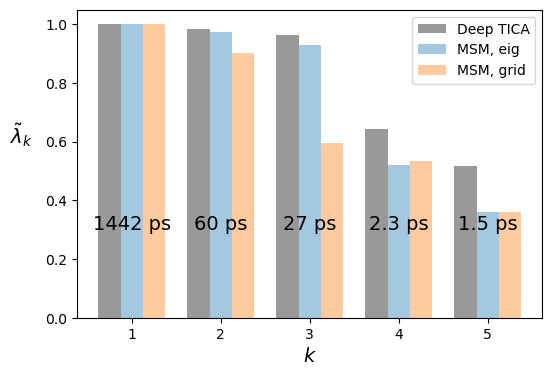

In [15]:
from src.plots import plot_eigvals

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_eigvals(ax, sd, eigvals_psi, eigvals_dill)
fig.savefig('figures/tica-msm-eigvals.png', bbox_inches='tight')
fig.savefig('figures/tica-msm-eigvals.svg', bbox_inches='tight')

# MFPT's

/tmp/ipykernel_53602/193879641.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(n) for n in range(0, 7)])
/tmp/ipykernel_53602/193879641.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(n) for n in range(0, 7)])


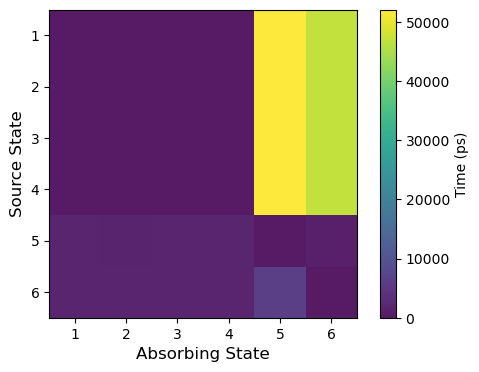

In [40]:
from src.util import mfpt_matrix

mfpt = mfpt_matrix(counts_psi[0], sd.lagtime)
# print(mfpt)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
cb = ax.imshow(mfpt, alpha=0.9)
ax.set_xticklabels([str(n) for n in range(0, 7)])
ax.set_yticklabels([str(n) for n in range(0, 7)])
ax.set_xlabel('Absorbing State', fontsize=12)
ax.set_ylabel('Source State', fontsize=12)
fig.colorbar(cb, label='Time (ps)')
fig.savefig('figures/mfpt.png', bbox_inches='tight')
fig.savefig('figures/mfpt.svg', bbox_inches='tight')

# Course-grain to two states

In [41]:
counts = counts_psi[0]
counts_cg = np.zeros((2, 2), dtype=int)
counts_cg[0, 0] = counts[:4, :4].sum()
counts_cg[0, 1] = counts[:4, 4:].sum()
counts_cg[1, 0] = counts[4:, :4].sum()
counts_cg[1, 1] = counts[4:, 4:].sum()
mfpt_cg = mfpt_matrix(counts_cg, sd.lagtime)
pi_cg = counts_cg.sum(axis=1) / counts_cg.sum()
print(f'{counts_cg = }')
print(f'{mfpt_cg = }')
print(f'{pi_cg = }')

counts_cg = array([[2898886,      62],
       [     62,  100989]])
mfpt_cg = array([[    0.        , 46757.22580646],
       [ 1629.85483871,     0.        ]])
pi_cg = array([0.96631632, 0.03368368])


# ACF for leading eigenfunctions

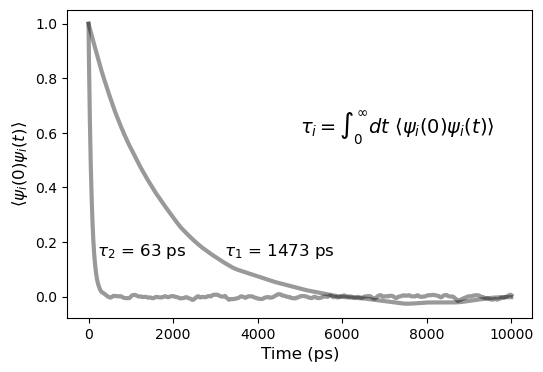

In [20]:
from src.util import timescale_from_acf

# tau, acf = timescale_from_acf(sd.psi[:, 0], sd.lagtime, num_points=10000)
# np.save('data/ala2_solv/acf-1.npy', acf)
tau1 = 1473.3157079835873
acf1 = np.load('data/ala2_solv/acf-1.npy')

# tau, acf = timescale_from_acf(sd.psi[:, 1], sd.lagtime, num_points=10000)
# np.save('data/ala2_solv/acf-2.npy', acf)
tau2 = 62.52672475655501
acf2 = np.load('data/ala2_solv/acf-2.npy')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(acf1, linewidth=3, alpha=0.4, color='black')
ax.plot(acf2, linewidth=3, alpha=0.4, color='black')
ax.set_xlabel('Time (ps)', fontsize=12)
ax.set_ylabel(r'$\langle\psi_i(0)\psi_i(t)\rangle$', fontsize=12) #, $C(t)$')
ax.text(3200, 0.15, r'$\tau_1$ = 1473 ps', fontsize=12)
ax.text(200, 0.15, r'$\tau_2$ = 63 ps', fontsize=12)
ax.text(5000, 0.6, r'$\tau_i = \int_0^\infty dt~\langle\psi_i(0)\psi_i(t)\rangle$', fontsize=14)
fig.savefig('figures/acf.png', bbox_inches='tight')
fig.savefig('figures/acf.svg', bbox_inches='tight')